[INFO] [1745543816.958227865] [rosbag2_storage]: Opened database '/home/andal/EECE5554/LAB4/Data/data_driving.bag/data_driving.bag_0.db3' for READ_ONLY.


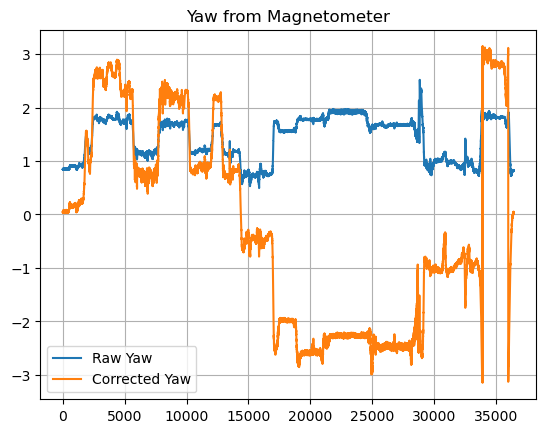

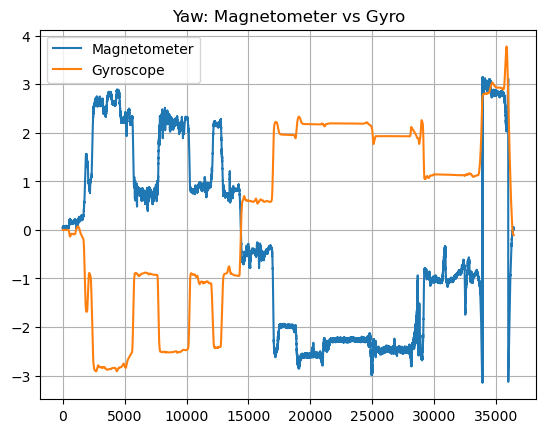

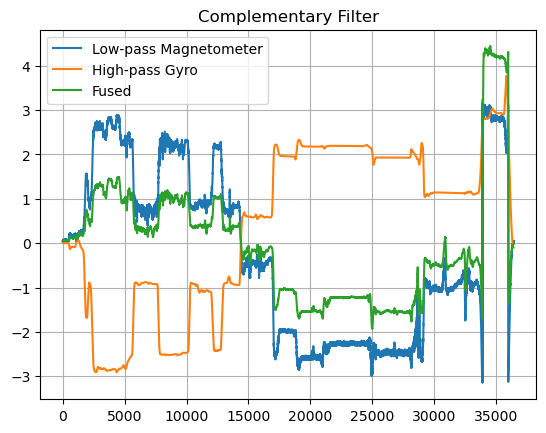

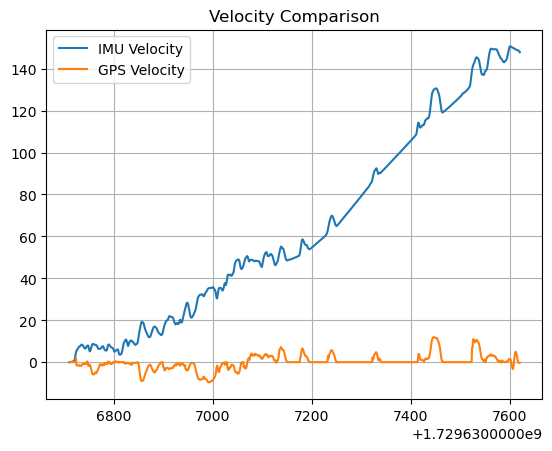

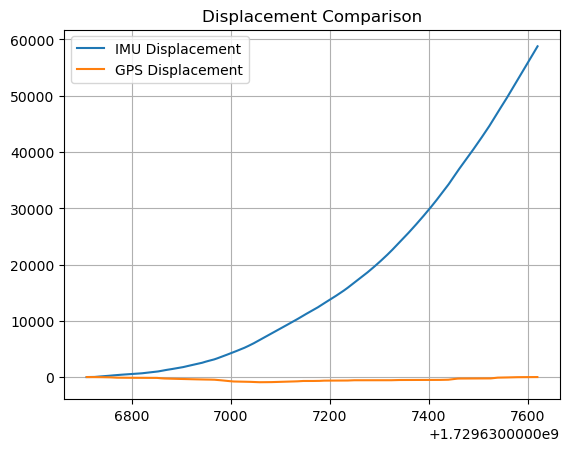

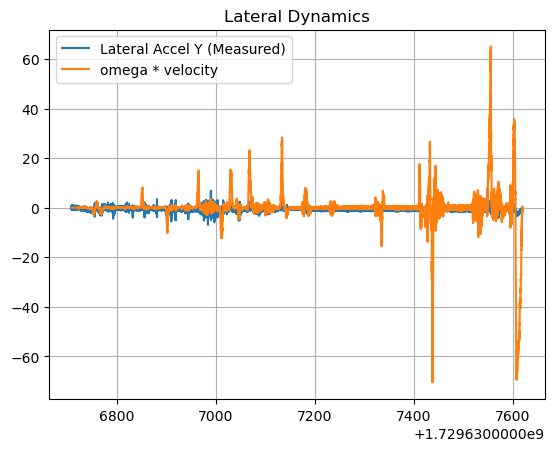

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from scipy.signal import butter, filtfilt
from gps_interfaces.msg import GPSmsg
from imu_interfaces.msg import IMUmsg
from rclpy.serialization import deserialize_message
import rosbag2_py
from rosidl_runtime_py.utilities import get_message

# Complementary filter parameter
ALPHA = 0.95

# ---------------------- Data Loading ----------------------
def load_bag_data(bagfile_path):
    storage_options = rosbag2_py.StorageOptions(uri=bagfile_path, storage_id="sqlite3")
    converter_options = rosbag2_py.ConverterOptions(input_serialization_format="cdr", output_serialization_format="cdr")
    reader = rosbag2_py.SequentialReader()
    reader.open(storage_options, converter_options)

    imu_data, gps_data = [], []
    while reader.has_next():
        topic, data, _ = reader.read_next()
        if topic == "/imu":
            imu_msg = deserialize_message(data, IMUmsg)
            imu_data.append(imu_msg)
        elif topic == "/gps":
            gps_msg = deserialize_message(data, GPSmsg)
            gps_data.append(gps_msg)

    return imu_data, gps_data

# ---------------------- Filters ----------------------
def apply_filter(data, cutoff, fs, filter_type="low"):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(N=1, Wn=normal_cutoff, btype=filter_type, analog=False)
    return filtfilt(b, a, data)

# ---------------------- Magnetometer Calibration ----------------------
def magnetometer_calibration(mag_data):
    bias = np.mean(mag_data, axis=0)
    corrected = mag_data - bias
    return corrected, bias

# ---------------------- Yaw Estimation ----------------------
def compute_yaw_from_magnetometer(mag_data):
    corrected_mag, _ = magnetometer_calibration(mag_data)
    raw_yaw = np.arctan2(mag_data[:, 1], mag_data[:, 0])
    corrected_yaw = np.arctan2(corrected_mag[:, 1], corrected_mag[:, 0])
    return raw_yaw, corrected_yaw

def integrate_gyro_yaw(gyro_z, imu_time):
    dt = np.diff(imu_time, prepend=imu_time[0])
    return np.cumsum(gyro_z * dt)

def apply_complementary_filter(gyro_yaw, corrected_yaw_mag, imu_time):
    complementary_yaw = [corrected_yaw_mag[0]]
    for i in range(1, len(corrected_yaw_mag)):
        dt = imu_time[i] - imu_time[i - 1]
        gyro_est = complementary_yaw[-1] + gyro_yaw[i] * dt
        combined = ALPHA * gyro_est + (1 - ALPHA) * corrected_yaw_mag[i]
        complementary_yaw.append(combined)
    return np.array(complementary_yaw)

# ---------------------- Velocity Estimation ----------------------
def integrate_velocity(accel_data, imu_time):
    fs = 1.0 / np.mean(np.diff(imu_time))
    filtered_acc = apply_filter(accel_data, cutoff=0.25, fs=fs)
    bias = np.mean(filtered_acc[:100])
    corrected = filtered_acc - bias
    return cumulative_trapezoid(corrected, imu_time, initial=0)

# ---------------------- Processing Pipeline ----------------------
def process_data(bagfile_path):
    imu_data, gps_data = load_bag_data(bagfile_path)

    imu_time = np.array([msg.header.stamp.sec + msg.header.stamp.nanosec * 1e-9 for msg in imu_data])
    gps_time = np.array([msg.header.stamp.sec + msg.header.stamp.nanosec * 1e-9 for msg in gps_data])

    gyro_z = np.array([msg.imu.angular_velocity.z for msg in imu_data])
    mag_data = np.array([[msg.mag_field.magnetic_field.x, msg.mag_field.magnetic_field.y] for msg in imu_data]) * 1e6
    accel_x = np.array([msg.imu.linear_acceleration.x for msg in imu_data])
    accel_y = np.array([msg.imu.linear_acceleration.y for msg in imu_data])

    raw_yaw_mag, corrected_yaw_mag = compute_yaw_from_magnetometer(mag_data)
    yaw_gyro = integrate_gyro_yaw(gyro_z, imu_time)
    yaw_fused = apply_complementary_filter(yaw_gyro, corrected_yaw_mag, imu_time)

    imu_velocity = integrate_velocity(accel_x, imu_time)
    omega_velocity = gyro_z * imu_velocity

    utm_east = np.array([msg.utm_easting for msg in gps_data])
    gps_time_unique, idx = np.unique(gps_time, return_index=True)
    utm_east = utm_east[idx]
    gps_velocity = np.diff(utm_east) / np.diff(gps_time_unique)
    gps_velocity = np.insert(gps_velocity, 0, 0)
    gps_disp = utm_east - utm_east[0]

    imu_disp = cumulative_trapezoid(imu_velocity, imu_time, initial=0)

    # ------------- Plotting -------------
    plt.figure(); plt.plot(raw_yaw_mag, label='Raw Yaw'); plt.plot(corrected_yaw_mag, label='Corrected Yaw'); plt.legend(); plt.grid(); plt.title("Yaw from Magnetometer")
    plt.figure(); plt.plot(corrected_yaw_mag, label='Magnetometer'); plt.plot(yaw_gyro, label='Gyroscope'); plt.legend(); plt.grid(); plt.title("Yaw: Magnetometer vs Gyro")
    plt.figure(); plt.plot(corrected_yaw_mag, label='Low-pass Magnetometer'); plt.plot(yaw_gyro, label='High-pass Gyro'); plt.plot(yaw_fused, label='Fused'); plt.legend(); plt.grid(); plt.title("Complementary Filter")
    plt.figure(); plt.plot(imu_time, imu_velocity, label='IMU Velocity'); plt.plot(gps_time_unique, gps_velocity, label='GPS Velocity'); plt.legend(); plt.grid(); plt.title("Velocity Comparison")
    plt.figure(); plt.plot(imu_time, imu_disp, label='IMU Displacement'); plt.plot(gps_time_unique, gps_disp, label='GPS Displacement'); plt.legend(); plt.grid(); plt.title("Displacement Comparison")
    plt.figure(); plt.plot(imu_time, accel_y, label='Lateral Accel Y (Measured)'); plt.plot(imu_time, omega_velocity, label='omega * velocity'); plt.legend(); plt.grid(); plt.title("Lateral Dynamics")
    plt.show()

# Example usage
bagfile_path = "/home/andal/EECE5554/LAB4/Data/data_driving.bag/data_driving.bag_0.db3"
process_data(bagfile_path)
